## UV/Vis optical absorption spectrum of semiconductors

Author: S. Tiwari (v1, 06/01/2024) <br>
Revision: F. Giustino (v1.1, 07/02/2024) <br>

In this Noteboook, we compute the optical absorption spectrum of silicon using 
1. The standard theory of indirect phonon-assisted absorption;
2. The quasi-degenerate perturbation theory (QDPT) method, which described both direct and indirect processes on the same footing. 

Electrons and phonons are computed with Quantum ESPRESSO (QE), maximally-localized Wannier functions are computed with Wannier90, and the optical spectra are computed with EPW. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import time, sys, os
import EPWpy
from EPWpy import EPWpy
from EPWpy.plotting import plot_bands
from EPWpy.QE.PW_util import *

Below we define constants that will remail unchanged throughout the Notebook. The object `silicon` is created as an instance of the `EPWpy` class. This object will contain everything that we need to execute and analyze the calculations.

In [2]:

silicon=EPWpy.EPWpy({'prefix':'si',
                     'calculation':'\'scf\'',
                     'ibrav':2,
                     'nat':2,
                     'ntyp':1,
                     'atomic_species':['Si'],
                     'mass':[28.0855],
                     'atoms':['Si','Si'],
                     'ecutwfc':'40',               
                     'celldm(1)':'10.262',         
                     'pseudo_auto':True
                    },
                    env='mpirun')

pseudopot=silicon.__dict__['pw_atomic_species']['pseudo'][0]
print('Pseudopotential:', silicon.__dict__['pw_atomic_species']['pseudo'][0])
print('Pseudopotential directory:', silicon.__dict__['pw_control']['pseudo_dir'])
print('Prefix:',silicon.__dict__['prefix'])


                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

### Self-consistent field (SCF) calculations

Here we perform the self-consistent field calculation to obtain the electron charge density of silicon in the ground state. The calculation consists of three separate steps:
1. Apply the method `scf` to the object `silicon`. This step specifies runtime parameters for an SCF calculation on siicon 
2. Based on the properties defined at step 1 as well as other properties that are set by default within EPWpy, the method `prepare` creates the input file needed by QE
3. The method `run` applied to the object `silicon` instructs QE to perform the SCF calculation

In [3]:
silicon.scf(name='scf',kpoints={'kpoints':[[6,6,6]]})  
silicon.prepare(type_run='scf')                   
silicon.run(4)
silicon.pw_util = silicon.PW_utilities()

-- -- -- -- -- -- -- -- -- -- --  Calculation: scf  -- -- -- -- -- -- -- -- -- -- -- 
Running scf |████████████████████████████████████████| in 2.4s (0.87/s)         

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Band structure calculation

In this step, we compute the band structure of silicon along some high-symmetry lines in the Brillouin zone.

This calculation is not strictly necessary to compute the mobility, but it is useful to understand the electronic structure of the system under consideration.

Also in this case, we use **three instructions** to specify runtime parameters, prepare the input file, and execute the QE calculation.

In [4]:
silicon.scf(control={'calculation':'\'bands\''},
            system={'nbnd':12},
            kpoints={'kpoints':[
                                ['0.5','0.50','0.50','20'],
                                ['0.0','0.00','0.00','20'],
                                ['0.5','0.25','0.75','20']
                               ],
                     'kpoints_type':'{crystal_b}'
                    },
            name='bs')
silicon.prepare(type_run='bs')
silicon.run(4,type_run='bs')

-- -- -- -- -- -- -- -- -- -- --  Calculation: bs  -- -- -- -- -- -- -- -- -- -- -- 
Running bs |████████████████████████████████████████| in 4.6s (0.35/s)          

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Band structure plot

We now plot the electronic band structure computed at the previous step. The zero of the energy axis is set to the value specified manually via `ef0`.

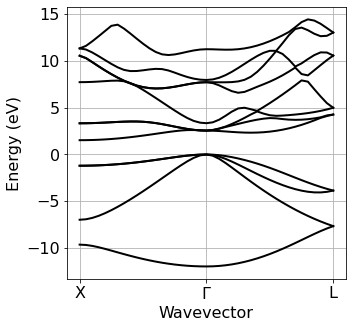

In [5]:
ef_from_file = silicon.pw_util.efermi  

Band=plot_bands.plot_band_scf(f'./{silicon.prefix}/bs/bs.out') 
plot_bands.plot_band_prod(Band,
                          ef0=ef_from_file,
                          xticks=['X','$\Gamma$','L'], 
                          xlabel = 'Wavevector',
                          ylabel = 'Energy (eV)' 
                         )


### Phonon dispersion relations

To compute phonon-limited mobilities, we need to determine vibrational frequencies and eigenmodes. This operation consists of three steps
1. We compute these properties on a uniform and centered Brillouin zone grid
2. We perform a Fourier transform of the results in order to obtain the interatomic force constants (IFCs)
3. We interpolate the IFCs along specified Brillouin zone paths to obtain phonon dispersions.

This plot of phonon dispersions is only meant for us to develop a qualitative understanding of the vibrational properties of the system under consideration. The phonon interpolation needed for calculations of the optical absorption spectrum is performed once again later by EPW.

#### Step 1: Calculations of phonons on uniform Brillouin zone grid

In [6]:
silicon.ph(phonons={'fildyn':'\'si.dyn\'',
                    'nq1':3,
                    'nq2':3,
                    'nq3':3,
                    'fildvscf':'\'dvscf\''}
          )
silicon.prepare(type_run='ph')
silicon.run(16,type_run='ph')            

-- -- -- -- -- -- -- -- -- -- --  Calculation: ph  -- -- -- -- -- -- -- -- -- -- -- 
Running ph |████████████████████████████████████████| in 34.1s (0.04/s)         

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Step 2: Generation of IFCs

In [7]:
silicon.q2r(name='q2r')
silicon.prepare(type_run='q2r')
silicon.run(1,type_run='q2r')

-- -- -- -- -- -- -- -- -- -- --  Calculation: q2r  -- -- -- -- -- -- -- -- -- -- -- 
Running q2r |████████████████████████████████████████| in 1.2s (4.75/s)         

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Step 3: Interpolation of IFCs and generation of phonon dispersions plot

The logic and syntax of this operation are the same as for the band structure plot above: three instructions to execute `matdyn.x` and then plotting.

-- -- -- -- -- -- -- -- -- -- --  Calculation: matdyn  -- -- -- -- -- -- -- -- -- -- -- 
Running matdyn |████████████████████████████████████████| in 1.7s (1.80/s)      

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


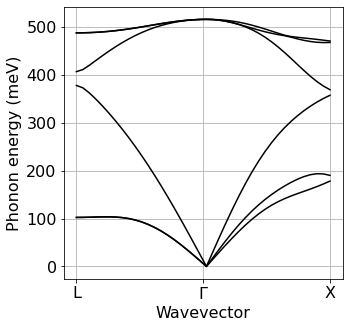

In [8]:
silicon.matdyn(name='matdyn',
               kpoints={'kpoints':[
                                   ['0.5','0.50','0.50','20'],
                                   ['0.0','0.00','0.00','20'],
                                   ['0.5','0.25','0.75','20']
                                 ],
                        'kpoints_type':'{crystal_b}'
                       },

              )
silicon.prepare(type_run='matdyn')
silicon.run(1,type_run='matdyn')           

Band=plot_bands.plot_band_eig(f'./{silicon.prefix}/ph/si.freq')
plot_bands.plot_band_freq(
                          Band,
                          xlabel='Wavevector',           
                          ylabel='Phonon energy (meV)',
                          ef0=0,
                          xticks=['L','$\Gamma$','X']
                          )

### Transformation of electrons and phonons to Wannier basis with EPW

Now we have Kohn-Sham wavefunctions and variations of the self-consistent Kohn-Sham potential on coarse Brillouin zone grid. We will generate the electron Hamiltonian, the IFCs, and the electron-phonon matrix elements in the Wannier representation using [EPW](https://epw-code.org/). Details on the underlying formalism can be found [here](https://arxiv.org/abs/1603.06965) (free version) or [here](https://doi.org/10.1103/RevModPhys.89.015003) (journal version).

This operation involves four logicals steps:
1. Compute Kohn-Sham states on a uniform centered Brillouin zone grid (QE)
2. Use EPW to load these states and call Wannier90 to generate Wannier functions
3. Use EPW to load IFCs and potential variations, and combine with 2. to compute electron-phonon matrix elements in the Bloch representation
4. Use EPW to perform the transformation to the Wannier basis and write to file

#### Step 1: Calculations of Kohn-Sham states on uniform Brillouin zone grid

In [9]:
silicon.nscf(system={'nbnd':8},
             kpoints={'grid':[6,6,6],'kpoints_type': 'crystal'})
silicon.prepare(type_run='nscf')
silicon.run(16,type_run='nscf')              

-- -- -- -- -- -- -- -- -- -- --  Calculation: nscf  -- -- -- -- -- -- -- -- -- -- -- 
Running nscf |████████████████████████████████████████| in 6.1s (0.25/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Steps 2-4: Load Bloch representation, Wannierize, write to file quantities in Wannier representation

In [12]:

# EPW run 1: Bloch to Wannier
silicon.filkf_file = 'LGX.txt'
silicon.epw(epwin={'wdata':['guiding_centres = .true.',
                            'dis_num_iter = 500',
                            'num_print_cycles  = 10',
                            'dis_mix_ratio = 1',
                            'use_ws_distance = T'],
                   'proj':['\'Si : sp3\''],
                   'band_plot':'.true.',
                   'filkf':silicon.filkf_file,
                   'filqf':silicon.filkf_file,
                   'etf_mem':0,
                   'fsthick':12.0,
                   'wannierize':'.true.', 
                   'num_iter':500
                  },
            name='epw1')

# File with k-path for sanity checks

silicon.filkf(path=[[0.5,0.5,0.5],
                    [0.0,0.0,0.0],
                    [0.5,0.25,0.75]],
              length=[51,51]                        
             )

silicon.prepare(type_run='epw1') 
silicon.run(16,type_run='epw1')

(4, 3)
[51, 51, 51]
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw1  -- -- -- -- -- -- -- -- -- -- -- 
Running epw1 |████████████████████████████████████████| in 35.8s (0.04/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Sanity check: Interpolated bands and phonons from EPW

At this point we have all necessary quantities in the Wannier representation on file. As a sanity check, we perform a simple interpolation of bands and phonons to make sure that we reproduce the results found above _without_ Wannier interpolation.

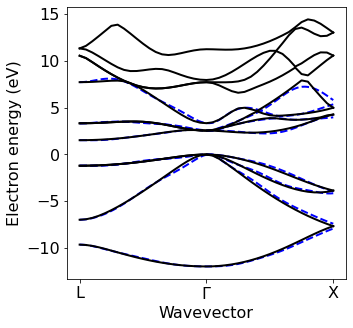

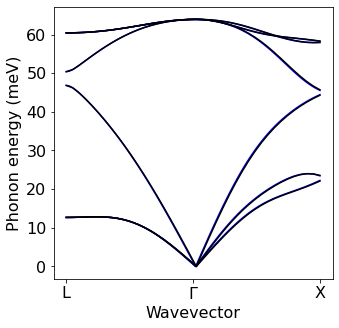

In [13]:
# Electrons

Band_EPW=plot_bands.plot_band_eig(f'./{silicon.prefix}/epw/band.eig')
Band_QE=plot_bands.plot_band_scf(f'./{silicon.prefix}/bs/bs.out')

plot_bands.plot_band_prod(Band_EPW,
                          ef0=ef_from_file,
                          xlabel='Wavevector',          
                          ylabel='Electron energy (eV)',
                          xticks=['L','$\Gamma$','X'],linestyle='--',color_c='b',color_v='b',first = True)
plot_bands.plot_band_prod(Band_QE,
                          ef0=ef_from_file,
                          xlabel='Wavevector',           
                          ylabel='Electron energy (eV)',
                          xticks=['L','$\Gamma$','X'],first = False) # False controls if this is the first set of plots 

# Phonons

PH_epw=plot_bands.plot_band_eig(f'./{silicon.prefix}/epw/phband.freq')
PH_matdyn=plot_bands.plot_band_eig(f'./{silicon.prefix}/ph/si.freq')
PH_matdyn=PH_matdyn*0.124

plot_bands.plot_band_freq(PH_epw,
                          xlabel='Wavevector',           
                          ylabel='Phonon energy (meV)',
                          ef0=0,
                          xticks=['L','$\Gamma$','X'],linestyle='--',first = True,color='blue')

plot_bands.plot_band_freq(PH_matdyn,
                          xlabel='Wavevector',           
                          ylabel='Phonon energy (meV)',
                          ef0=0,
                          xticks=['L','$\Gamma$','X'],first = False)


### Calculation of optical absorption spectrum: Standard method

In order to compute the absorption spectrum, we perform the following operations:
1. We interpolate the electrons, phonons, and electron-phonon couplings onto a fine Brillouin zone grid (20 x 20 x 20 for electrons and 10 x 10 x 10 phonons in this example; for production runs you will need finer grids)
2. We use these data to compute the imaginary part of the dielectric function with EPW

Both steps are performed within a single call of EPW. Note the keyword `lindabs` which selects the standard formula of phonon-assisted indirect absorption, and the keyword `degauss` which is used to broaden the spectrum and avoid singular denominators. 

The formulas employed in this approach can be found in [Phys. Rev. B 109, 195127 (2024)](https://doi.org/10.1103/PhysRevB.109.195127), specifically Eqs. (1), (3), and (9)-(13).

In [14]:
silicon.epw(epwin={'etf_mem': '1',
                   'omegamin':0.05,
                   'omegamax':4.0,
                   'omegastep':0.05,
                   'lindabs':'.true.',
                   'nkf1':30,
                   'nkf2':30,
                   'nkf3':30,
                   'nqf1':6,
                   'nqf2':6,
                   'nqf3':6,  
                   'mp_mesh_k':'.true.',
                   'efermi_read':'.true.',
                   'fermi_energy':6.5,
                   'lpolar':'.true.',
                   'fsthick': 5.5,
                   'temps':300 ,
                   'degaussw':0.1},
            name='epw2')
silicon.prepare(type_run='epw2')
silicon.run(16,type_run='epw2')

-- -- -- -- -- -- -- -- -- -- --  Calculation: epw2  -- -- -- -- -- -- -- -- -- -- -- 
Running epw2 |████████████████████████████████████████| in 37.2s (0.04/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Plot of the absorption spectrum: Standard method

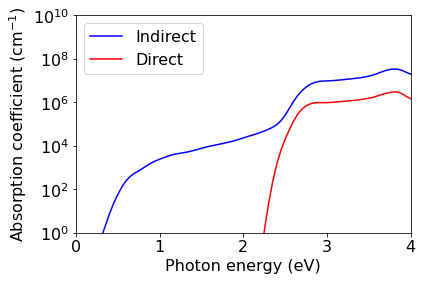

In [16]:
nr = 3.673              # Refractive index of silicon at 1.5 eV, from Aspnes and Studna 1983                   
hbar = 1.054571*10**-34 # Planck constant in SI units
c = 2.9979e+08          # Speed of light in SI units
eVtoJ = 1.60218e-19     # Energy conversion from eV to J  

# Indirect absorption

eps2 = np.loadtxt(f'./{silicon.prefix}/epw/epsilon2_indabs_300.0K.dat')
omega = eps2[:,0]                                            # omega in eV
alpha = (omega/(float(hbar*c)*nr))*eps2[:,4]*eVtoJ/100   # alpha in cm-1
plt.semilogy(omega,alpha,color='b',label='Indirect')

# Direct absorption

eps2 = np.loadtxt(f'./{silicon.prefix}/epw/epsilon2_dirabs_300.0K.dat')
omega = eps2[:,0]                                           # omega in eV
alpha = (omega/(float(hbar*c)*nr))*eps2[:,4]*eVtoJ/100      # alpha in cm-1
plt.semilogy(omega,alpha,color='r',label='Direct') 

plt.tick_params('x',labelsize=16)
plt.tick_params('y',labelsize=16)
plt.xlabel('Photon energy (eV)',fontsize=16)
plt.ylabel('Absorption coefficient (cm$^{-1}$)',fontsize=16)
plt.legend(fontsize=16)
plt.axis([0, 4, 1e0, 1e10])
plt.show()

### Calculation of optical absorption spectrum: QDPT

In Quasi-Degenerate Perturbation Theory (QDPT), both direct and phonon-assisted contributions to the optical absoprtion spectrum are computed using a single generalized formula. This approach eliminates the problem of singular denominators that is encountered with the standard theory when `degauss` tends to zero.

The formulas employed in this approach can be found in [Phys. Rev. B 109, 195127 (2024)](https://doi.org/10.1103/PhysRevB.109.195127), specifically Eqs. (1) and (48).

In order to compute the absorption spectrum, we perform the following operations:
1. We interpolate the electrons, phonons, and electron-phonon couplings onto a fine Brillouin zone grid (20 x 20 x 20 for electrons and 4 x 4 x 4 phonons in this example; for production runs you will need finer grids)
2. We use these data to compute the imaginary part of the dielectric function with EPW

Both steps are performed within a single call of EPW. Note the keyword `loptabs` which instructs the code to use QDPT. 

In [39]:
silicon.epw(epwin={'etf_mem': '1',
                   'omegamin':0.055,
                   'omegamax':2.8,
                   'omegastep':0.05,
                   'loptabs':'.true.',
                   'nkf1':24,
                   'nkf2':24,
                   'nkf3':24,
                   'nqf1':3,
                   'nqf2':3,
                   'nqf3':3,  
                   'mp_mesh_k':'.true.',
                   'efermi_read':'.true.',
                   'fermi_energy':6.55,
                   'lpolar':'.true.',
                   'fsthick': 5.5,
                   'temps':300 ,
                   'degaussw':0.1,
                   'nq_init':-1},
            name='epw2')
silicon.prepare(type_run='epw2')
silicon.run(8,type_run='epw2')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- Info -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Based on previous pw and ph calculations some parameters are set below
lpolar:  .true. (related to epsil in ph)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw2  -- -- -- -- -- -- -- -- -- -- -- 
Running epw2 |████████████████████████████████████████| in 9.1s (0.16/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Plot of the absorption spectrum: QDPT method

Now we compare the results of the QDPT approach with the standard formula for phonon-assisted absorption and with the direct absorption spectrum.

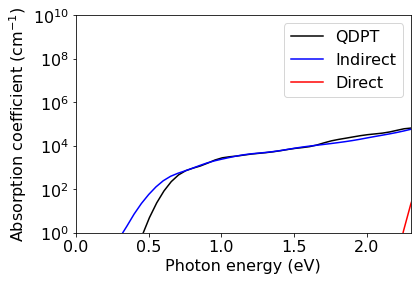

In [40]:
# QDPT absorption

eps2 = np.loadtxt(f'./{silicon.prefix}/epw/epsilon2_indabs_300.0K_12.dat')
omega = eps2[:,0]                                            # omega in eV
alpha = (omega/(float(hbar*c)*nr))*eps2[:,4]*eVtoJ/100       # alpha in cm-1
plt.semilogy(omega,alpha,color='k',label='QDPT')             


# Indirect absorption

eps2 = np.loadtxt(f'./{silicon.prefix}/epw/epsilon2_indabs_300.0K.dat')
omega = eps2[:,0]                                            # omega in eV
alpha = (omega/(float(hbar*c)*nr))*eps2[:,4]*eVtoJ/100   # alpha in cm-1
plt.semilogy(omega,alpha,color='b',label='Indirect')

# Direct absorption

eps2 = np.loadtxt('./si/epw/epsilon2_dirabs_300.0K.dat')
omega = eps2[:,0]                                            # omega in eV
alpha = (omega/(float(hbar*c)*nr))*eps2[:,4]*eVtoJ/100       # alpha in cm-1
plt.semilogy(omega,alpha,color='r',label='Direct') 

plt.tick_params('x',labelsize=16)
plt.tick_params('y',labelsize=16)
plt.xlabel('Photon energy (eV)',fontsize=16)
plt.ylabel('Absorption coefficient (cm$^{-1}$)',fontsize=16)
plt.legend(fontsize=16)
plt.axis([0, 2.3, 1e0, 1e10])
plt.show()